<a href="https://colab.research.google.com/github/abhinavdayal/EVA4/blob/master/S8/EVA04_S8_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# mount the drive where we will save stats and loade our libraries from
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
import eva4datatransforms
from torchvision import transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
trans = eva4datatransforms.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()


In [4]:
tuple(fillmeans)

(125, 122, 113)

# Dataset and Creating Train/Test Split

In [4]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 3, 32, 32])
torch.Size([128])


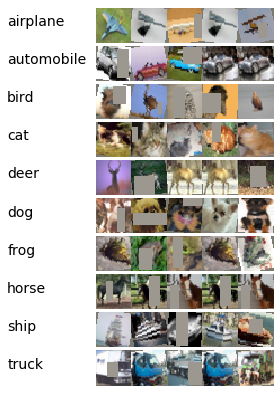

In [6]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model

## Target
1. Less than 7000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 6%

## Results
1. Number of Parameters = 6202 + 140 non trainable BN params
2. Best Train Accuracy = 98.97
3. Best Test Accuracy = 99.45

## Analysis
1. We pushed the model to achieve target with approx 6000 Parameters
2. Drop in accuracy was predicted because of making the training more difficult. But still we met the target.

# Model Creation

We will be creating Resnet18 model here.

We replaced FC with 1x1 as we are not supposed to use FC in this EVA4.

In [7]:
import eva4resnet
import torch
model = eva4resnet.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

# Let's Train and test our model

In [8]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 20
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.152085).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0113, Accuracy: 47.64%; Test set: Average loss: 1.1521, Accuracy: 61.14%
Learning Rate = 0.052181


Epoch: 2, Train set: Average loss: 0.0083, Accuracy: 62.46%; Test set: Average loss: 1.3142, Accuracy: 61.90%
Learning Rate = 0.140093


Validation loss decreased (1.152085 --> 0.824977).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0068, Accuracy: 69.71%; Test set: Average loss: 0.8250, Accuracy: 71.74%
Learning Rate = 0.260161


Validation loss decreased (0.824977 --> 0.779016).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0058, Accuracy: 73.86%; Test set: Average loss: 0.7790, Accuracy: 74.09%
Learning Rate = 0.380186


Validation loss decreased (0.779016 --> 0.602767).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0052, Accuracy: 76.92%; Test set: Average loss: 0.6028, Accuracy: 79.73%
Learning Rate = 0.467980


Validation loss decreased (0.602767 --> 0.472047).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0046, Accuracy: 79.23%; Test set: Average loss: 0.4720, Accuracy: 84.07%
Learning Rate = 0.500000


Epoch: 7, Train set: Average loss: 0.0042, Accuracy: 81.20%; Test set: Average loss: 0.4829, Accuracy: 83.73%
Learning Rate = 0.493700


Validation loss decreased (0.472047 --> 0.428219).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0038, Accuracy: 82.83%; Test set: Average loss: 0.4282, Accuracy: 85.73%
Learning Rate = 0.475180


Epoch: 9, Train set: Average loss: 0.0035, Accuracy: 84.22%; Test set: Average loss: 0.4534, Accuracy: 85.04%
Learning Rate = 0.445369


Validation loss decreased (0.428219 --> 0.416130).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0033, Accuracy: 85.35%; Test set: Average loss: 0.4161, Accuracy: 86.01%
Learning Rate = 0.405761


Validation loss decreased (0.416130 --> 0.370440).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0030, Accuracy: 86.34%; Test set: Average loss: 0.3704, Accuracy: 87.53%
Learning Rate = 0.358342


Validation loss decreased (0.370440 --> 0.365860).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0028, Accuracy: 87.65%; Test set: Average loss: 0.3659, Accuracy: 88.09%
Learning Rate = 0.305491


Validation loss decreased (0.365860 --> 0.355133).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0026, Accuracy: 88.50%; Test set: Average loss: 0.3551, Accuracy: 88.17%
Learning Rate = 0.249858


Validation loss decreased (0.355133 --> 0.326992).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0023, Accuracy: 89.51%; Test set: Average loss: 0.3270, Accuracy: 89.36%
Learning Rate = 0.194231


Validation loss decreased (0.326992 --> 0.319265).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0021, Accuracy: 90.50%; Test set: Average loss: 0.3193, Accuracy: 89.84%
Learning Rate = 0.141401


Validation loss decreased (0.319265 --> 0.298606).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0019, Accuracy: 91.75%; Test set: Average loss: 0.2986, Accuracy: 90.69%
Learning Rate = 0.094017


Validation loss decreased (0.298606 --> 0.288520).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0016, Accuracy: 92.98%; Test set: Average loss: 0.2885, Accuracy: 91.09%
Learning Rate = 0.054454


Validation loss decreased (0.288520 --> 0.280281).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0014, Accuracy: 93.77%; Test set: Average loss: 0.2803, Accuracy: 91.32%
Learning Rate = 0.024697


Validation loss decreased (0.280281 --> 0.278634).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0012, Accuracy: 94.68%; Test set: Average loss: 0.2786, Accuracy: 91.49%
Learning Rate = 0.006238


Validation loss decreased (0.278634 --> 0.276738).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0011, Accuracy: 95.01%; Test set: Average loss: 0.2767, Accuracy: 91.61%
Learning Rate = 0.000002

